In [20]:
%matplotlib inline
import networkx as nx
import metis
import random
import string
from tqdm import tqdm
from itertools import chain
from matplotlib import pyplot as plt
from collections import Counter, defaultdict
import pandas as pd

In [21]:
GAMMA = 1.5

In [22]:
def get_alpha(g, k=2, gamma=GAMMA):
    return np.sqrt(k) * g.number_of_edges() / np.power(g.number_of_nodes(), GAMMA)

In [37]:
def attempt_reassignment(g, n, partition, node2cluster, gamma, alpha):    
    c_star = best_cluster_id(g, n, partition, gamma, alpha)
    did_it = False
    node_exist = (n in node2cluster)
    if node_exist:
        if node2cluster[n] != c_star:
            partition[node2cluster[n]].remove(n)
            partition[c_star].add(n)
            node2cluster[n] = c_star
            did_it = True
    else:
        partition[c_star].add(n)
        node2cluster[n] = c_star
        did_it = True
    return did_it, partition, node2cluster

def best_cluster_id(g, u, part, gamma, alpha):
    """part: dict(cluster_id, set of node)
             the partition information
        alpha, gamma: balancing parameter"""
    N_u = set(g.neighbors(u))
    def score(c):
        s = (len(part[c].intersection(N_u)) -
                alpha * gamma / 2 * np.power(len(part[c]), gamma-1))
        return s
    return max(part, key=score)

In [38]:
def update_partition(g, node_cluster_ids, k=2,
                     edges_to_add=[], edges_to_remove=[],
                     gamma=GAMMA,
                     verbose=True):
    """
    incrementally update the partitioning

    node_cluster_ids: list of cluster ids
    
    return:
        list of updated cluster ids
        
    note that edges are added/removed inside this function
    """
    if len(edges_to_add) == 0 and len(edges_to_remove) == 0:
        print('nothing to update')
        return node_cluster_ids
    
    partition = defaultdict(set)  # cluster id to list of nodes
    for p, n in zip(node_cluster_ids, g.nodes_iter()):
        partition[p].add(n)
    node2cluster = dict(zip(g.nodes(), node_cluster_ids))  # node to cluster id
    
    # print(node2cluster)
    g.add_edges_from(edges_to_add)
    g.remove_edges_from(edges_to_remove)

    alpha = get_alpha(g, gamma=gamma)
    params = {'gamma': gamma, 'alpha': alpha}
    edge_iters = chain(edges_to_add, edges_to_remove)
    if verbose:
        iters = tqdm(edge_iters)

    for u, v in edge_iters:
        if verbose:
            print('edge ({}, {})'.format(u, v))
        affected_nodes = set()
        did_it, partition, node2cluster = attempt_reassignment(g, u,
                                                               partition,
                                                               node2cluster,
                                                               **params)
        if did_it:
            if verbose:
                print('moved node {}'.format(u))
            affected_nodes |= set(g.neighbors(u))
        did_it, partition, node2cluster = attempt_reassignment(g, v,
                                                               partition,
                                                               node2cluster,
                                                               **params)
        if did_it:
            if verbose:
                print('moved node {}'.format(v))
            affected_nodes |= set(g.neighbors(v))

        for n in affected_nodes:
            if True:
                did_it, partition, node2cluster = attempt_reassignment(
                    g, n, partition, node2cluster, **params)
                if verbose:
                    if did_it:
                        print('moved node {}'.format(n))      
                    else:
                        print('{} stayed'.format(n))

    return [node2cluster[n] for n in g.nodes_iter()]

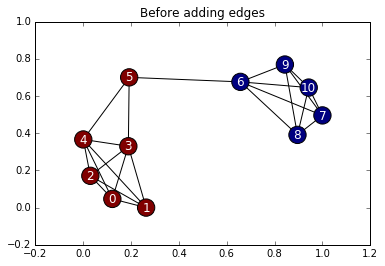

In [51]:
g = nx.barbell_graph(5, 1)
g.add_edge(3, 5)

_, part = metis.part_graph(g, 2)

nx.draw_networkx(g, font_color='white', node_color=part)
plt.title('Before adding edges')


0it [00:00, ?it/s]


edge (5, 7)
moved node 5
8 stayed
3 stayed
4 stayed
6 stayed
7 stayed
edge (5, 8)
edge (0, 11)
moved node 11
0 stayed


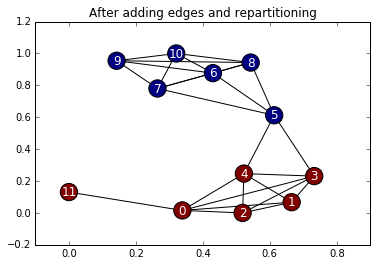

In [52]:
part = update_partition(g, node_cluster_ids=part, edges_to_add=[(5, 7), (5, 8), (0, 11)])
nx.draw_networkx(g, font_color='white', node_color=part)
plt.title('After adding edges and repartitioning')


0it [00:00, ?it/s]

edge (5, 7)
moved node 5
3 stayed
4 stayed
6 stayed
edge (5, 8)


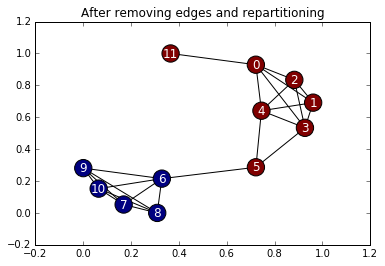

In [53]:
part = update_partition(g, node_cluster_ids=part, edges_to_remove=[(5, 7), (5, 8)])
nx.draw_networkx(g, font_color='white', node_color=part)
plt.title('After removing edges and repartitioning')

In [61]:
def get_cut_ratio(g, cluster_node_ids):
    """support only 2 partitions currently                                                                                                                    
    """
    partition = defaultdict(set)
    for n, c in zip(g.nodes_iter(), cluster_node_ids):
        partition[c].add(n)
                                                                                                                                                              
    c1, c2 = list(partition.values())
    cuts = 0.0
    for u, v in g.edges_iter():
        if (u in c1 and v in c2) or (u in c2 and v in c1):
            cuts += 1
    return (cuts / g.number_of_edges(), c1, c2)

In [60]:
def performance(g, updated_cluster_ids, raw_cuts, raw_cluster_ids):
    r1, c1, c2 = get_cut_ratio(g, updated_cluster_ids)
    size_1 = (len(c1), len(c2))
    
    r2 = raw_cuts / g.number_of_edges()     
    size_2 = tuple(Counter(raw_cluster_ids).values())
    return {'cut_ratio_1': r1, 
            'cut_ratio_2': r2,
            'size_1': size_1,
            'size_2': size_2}

In [63]:
cuts, raw_parts = metis.part_graph(g, 2)
performance(g, part, cuts, raw_parts)

{'cut_ratio_1': 0.041666666666666664,
 'cut_ratio_2': 0.08333333333333333,
 'size_1': (5, 7),
 'size_2': (6, 6)}

In [30]:
def sample_edges_to_add(g, n_edges_to_add,
                        unknown_nodes_pool=list(string.ascii_lowercase)):
    n = 0
    edges_to_add = []
    nodes = g.nodes()
    while n < n_edges_to_add:
        while True:
            u = v = random.choice(nodes)
                                                                                                                                                              
            if random.random() > 0.5:  # 0.5 proba to sample unknown nodes                                                                                    
                edges_to_add.append((u, random.choice(unknown_nodes_pool)))
                break
            else:  # 0.5 proba to sample existing edge                                                                                                        
                while u == v:
                    v = random.choice(nodes)
                if not g.has_edge(u, v):
                    edges_to_add.append((u, v))
                    break
        n += 1
    return edges_to_add

In [31]:
# test
assert len(sample_edges_to_add(g, 10)) == 10
for e in sample_edges_to_add(g, 10):
    assert not g.has_edge(*e)

In [64]:
# Experiment on real networks
from glob import glob
from time import time


add_edges_percent = 0.01
remove_edges_percent = 0.01

rows = []
for path in tqdm(glob('data/*.gpkl')):
    name = os.path.basename(path).split('.')[0]
    print(name)
    g = nx.read_gpickle(path)
    _, parts = metis.part_graph(g, 2)
    
    edges_to_remove = random.sample(g.edges(), int(g.number_of_edges() * remove_edges_percent))
    edges_to_add = sample_edges_to_add(g, int(g.number_of_edges() * add_edges_percent))

    s = time()
    
    updated_parts = update_partition(g, 
                                     node_cluster_ids=parts,
                                     edges_to_add=edges_to_add,
                                     edges_to_remove=edges_to_remove,
                                     verbose=False)
    takes_time_1 = time() - s
    
    s = time()
    raw_cuts, raw_parts = metis.part_graph(g, 2)
    takes_time_2 = time() - s
    
    stat = performance(g, updated_parts, raw_cuts, raw_parts)
    stat['name'] = name
    stat['running_time_1'] = takes_time_1
    stat['running_time_2'] = takes_time_2
    rows.append(stat)


  0%|          | 0/8 [00:00<?, ?it/s]

circular



 12%|█▎        | 1/8 [00:01<00:12,  1.81s/it]

mtvhottest



 25%|██▌       | 2/8 [00:06<00:16,  2.70s/it]

barbell



Exception in thread Thread-16:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/cloud-user/code/controversy_detection/venv/lib/python3.5/site-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

 38%|███▊      | 3/8 [00:31<00:46,  9.35s/it]

star


 50%|█████     | 4/8 [00:39<00:35,  8.90s/it]

beefban


 62%|██████▎   | 5/8 [00:40<00:19,  6.67s/it]

baltimore


 75%|███████▌  | 6/8 [00:46<00:12,  6.24s/it]

ukraine


 88%|████████▊ | 7/8 [00:49<00:05,  5.31s/it]

barabasi


100%|██████████| 8/8 [00:53<00:00,  4.95s/it]


In [65]:
df = pd.DataFrame.from_records(rows)

In [66]:
df.head(2)

,cut_ratio_1,cut_ratio_2,name,running_time_1,running_time_2,size_1,size_2
0,0.004640,0.000940,circular,0.113140,0.523840,"(25013, 25013)","(25013, 25013)"
1,0.009931,0.008883,mtvhottest,1.113234,1.387584,"(31681, 31680)","(31680, 31681)"


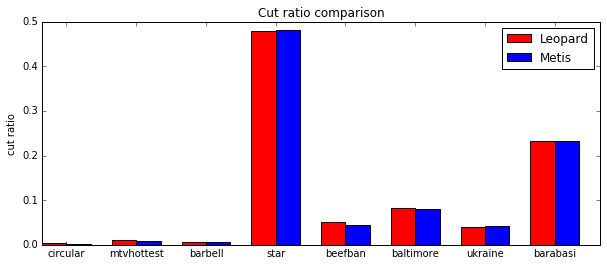

In [67]:
# cut ratio
fig, ax = plt.subplots()

N = df.shape[0]
ind = np.arange(N)
width = 0.35

ax.bar(ind, df['cut_ratio_1'], width, color='red')
ax.bar(ind+width, df['cut_ratio_2'], width, color='blue')

ax.set_xticks(ind + width)
ax.set_xticklabels(df['name'])
ax.set_ylabel('cut ratio')
ax.set_title('Cut ratio comparison')
fig.set_figwidth(10)
ax.legend(['Leopard', 'Metis'])

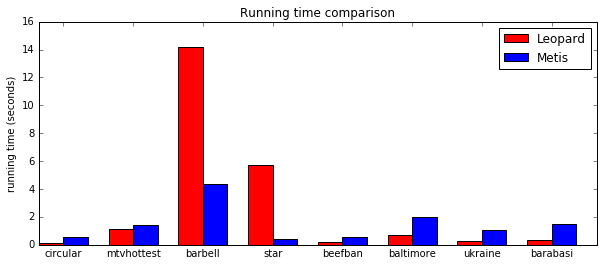

In [68]:
# cut ratio
fig, ax = plt.subplots()

N = df.shape[0]
ind = np.arange(N)
width = 0.35

ax.bar(ind, df['running_time_1'], width, color='red')
ax.bar(ind+width, df['running_time_2'], width, color='blue')

ax.set_xticks(ind + width)
ax.set_xticklabels(df['name'])
ax.set_ylabel('running time (seconds)')
ax.set_title('Running time comparison')
fig.set_figwidth(10)
ax.legend(['Leopard', 'Metis'])